In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [3]:
import os
SEQ_LEN = 64
IM_SIZE = 28

In [4]:
def read_img_sequences(path_to_folder, size=200):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * SEQ_LEN
        sequence_labels = [None] * SEQ_LEN
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(IM_SIZE * IM_SIZE).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [5]:
anomaly_data, anomaly_labels = read_img_sequences('img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('img_ts_normal/')

In [6]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [8]:
device = torch.device('cuda')

In [9]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [10]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [11]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [12]:
# input data parameters
input_size = IM_SIZE * IM_SIZE
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [13]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [14]:
device = torch.device("cuda:1")

In [15]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [16]:
def train_model(model, loss_function, epochs=100, print_every=5, LSTM_flag = True):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

## LSTM Model

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [18]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [21]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)

Epoch: 2/60... Step: 5... Loss: -15.047619... Val Loss: -14.866448
Epoch: 4/60... Step: 10... Loss: -14.964939... Val Loss: -16.225769
Epoch: 5/60... Step: 15... Loss: -11.762266... Val Loss: -16.278120
Epoch: 7/60... Step: 20... Loss: -15.335474... Val Loss: -15.870225
Epoch: 9/60... Step: 25... Loss: -12.008268... Val Loss: -15.016895
Epoch: 10/60... Step: 30... Loss: -14.427399... Val Loss: -14.424994
Epoch: 12/60... Step: 35... Loss: -14.725451... Val Loss: -15.229468
Epoch: 14/60... Step: 40... Loss: -11.806919... Val Loss: -13.317175
Epoch: 15/60... Step: 45... Loss: -16.896597... Val Loss: -15.176253
Epoch: 17/60... Step: 50... Loss: -14.999331... Val Loss: -17.068048
Epoch: 19/60... Step: 55... Loss: -14.727432... Val Loss: -14.060367
Epoch: 20/60... Step: 60... Loss: -14.418851... Val Loss: -19.062035
Epoch: 22/60... Step: 65... Loss: -13.992439... Val Loss: -16.586884
Epoch: 24/60... Step: 70... Loss: -15.436721... Val Loss: -14.715519
Epoch: 25/60... Step: 75... Loss: -13.80

In [22]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [23]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       60, 5, LSTM_flag=True)

Epoch: 2/60... Step: 5... Loss: 0.631168... Val Loss: 0.620364
Epoch: 4/60... Step: 10... Loss: 0.498089... Val Loss: 0.444863
Epoch: 5/60... Step: 15... Loss: 0.317841... Val Loss: 0.263569
Epoch: 7/60... Step: 20... Loss: 0.209879... Val Loss: 0.177861
Epoch: 9/60... Step: 25... Loss: 0.128975... Val Loss: 0.105785
Epoch: 10/60... Step: 30... Loss: 0.093022... Val Loss: 0.070854
Epoch: 12/60... Step: 35... Loss: 0.078733... Val Loss: 0.054011
Epoch: 14/60... Step: 40... Loss: 0.050765... Val Loss: 0.046382
Epoch: 15/60... Step: 45... Loss: 0.051153... Val Loss: 0.033438
Epoch: 17/60... Step: 50... Loss: 0.036340... Val Loss: 0.036288
Epoch: 19/60... Step: 55... Loss: 0.033102... Val Loss: 0.033221
Epoch: 20/60... Step: 60... Loss: 0.024279... Val Loss: 0.030096
Epoch: 22/60... Step: 65... Loss: 0.028234... Val Loss: 0.036391
Epoch: 24/60... Step: 70... Loss: 0.033374... Val Loss: 0.033505
Epoch: 25/60... Step: 75... Loss: 0.022932... Val Loss: 0.028159
Epoch: 27/60... Step: 80... Los

In [24]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [25]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, second_custom_loss_function, 30, 5, 
                                    LSTM_flag=True)

Epoch: 2/30... Step: 5... Loss: -1.940425... Val Loss: -2.097421
Epoch: 4/30... Step: 10... Loss: -2.848153... Val Loss: -3.459583
Epoch: 5/30... Step: 15... Loss: -3.921615... Val Loss: -4.551408
Epoch: 7/30... Step: 20... Loss: -5.037209... Val Loss: -5.867546
Epoch: 9/30... Step: 25... Loss: -7.390424... Val Loss: -7.848312
Epoch: 10/30... Step: 30... Loss: -7.526242... Val Loss: -7.770468
Epoch: 12/30... Step: 35... Loss: -8.228397... Val Loss: -12.456376
Epoch: 14/30... Step: 40... Loss: -11.962134... Val Loss: -11.974339
Epoch: 15/30... Step: 45... Loss: -11.770898... Val Loss: -14.264299
Epoch: 17/30... Step: 50... Loss: -10.605932... Val Loss: -12.807793
Epoch: 19/30... Step: 55... Loss: -14.190064... Val Loss: -11.562636
Epoch: 20/30... Step: 60... Loss: -13.254226... Val Loss: -14.345684
Epoch: 22/30... Step: 65... Loss: -10.544637... Val Loss: -10.850705
Epoch: 24/30... Step: 70... Loss: -13.421867... Val Loss: -15.214913
Epoch: 25/30... Step: 75... Loss: -10.667685... Val L

In [26]:
model_LSTM_combined, __ = train_model(model_LSTM_combined, first_bce_loss_function, 30, 5, 
                                      LSTM_flag=True)

Epoch: 2/30... Step: 5... Loss: 0.102339... Val Loss: 0.090828
Epoch: 4/30... Step: 10... Loss: 0.057598... Val Loss: 0.047057
Epoch: 5/30... Step: 15... Loss: 0.041474... Val Loss: 0.038287
Epoch: 7/30... Step: 20... Loss: 0.034617... Val Loss: 0.037674
Epoch: 9/30... Step: 25... Loss: 0.031319... Val Loss: 0.034391
Epoch: 10/30... Step: 30... Loss: 0.032928... Val Loss: 0.037047
Epoch: 12/30... Step: 35... Loss: 0.028139... Val Loss: 0.033825
Epoch: 14/30... Step: 40... Loss: 0.019383... Val Loss: 0.026580
Epoch: 15/30... Step: 45... Loss: 0.022751... Val Loss: 0.022182
Epoch: 17/30... Step: 50... Loss: 0.017880... Val Loss: 0.025117
Epoch: 19/30... Step: 55... Loss: 0.012877... Val Loss: 0.029130
Epoch: 20/30... Step: 60... Loss: 0.024336... Val Loss: 0.027245
Epoch: 22/30... Step: 65... Loss: 0.019330... Val Loss: 0.026757
Epoch: 24/30... Step: 70... Loss: 0.017034... Val Loss: 0.029443
Epoch: 25/30... Step: 75... Loss: 0.018916... Val Loss: 0.025018
Epoch: 27/30... Step: 80... Los

## FNN Models

In [27]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, drop_prob=0.5):
        super(FNN, self).__init__()
        # Linear function as in LSTM model

        self.linear_1 = nn.Linear(input_size, hidden_dim) 
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim//2) 
        self.linear_3 = nn.Linear(hidden_dim//2, 1)  
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()
        self.activation = nn.Sigmoid()


    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        out = self.linear_1(input_seq)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_3(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)
        return out

In [28]:
model_FNN_custom = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
loss_function = CustomLoss()
model_FNN_custom.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [29]:
model_FNN_custom, (loss_list, acc_list, overall_val_loss_list) = train_model(model_FNN_custom, loss_function, 
                                                                             20, 5, LSTM_flag=False)

Epoch: 2/20... Step: 5... Loss: -2.012522... Val Loss: -2.388057
Epoch: 4/20... Step: 10... Loss: -3.285161... Val Loss: -3.815486
Epoch: 5/20... Step: 15... Loss: -4.369187... Val Loss: -5.384285
Epoch: 7/20... Step: 20... Loss: -7.242140... Val Loss: -7.265909
Epoch: 9/20... Step: 25... Loss: -6.133723... Val Loss: -7.010209
Epoch: 10/20... Step: 30... Loss: -7.737756... Val Loss: -7.664022
Epoch: 12/20... Step: 35... Loss: -8.110338... Val Loss: -6.610047
Epoch: 14/20... Step: 40... Loss: -7.015589... Val Loss: -7.319884
Epoch: 15/20... Step: 45... Loss: -7.365215... Val Loss: -7.353231
Epoch: 17/20... Step: 50... Loss: -7.466478... Val Loss: -7.406581
Epoch: 19/20... Step: 55... Loss: -8.353004... Val Loss: -7.706716
Epoch: 20/20... Step: 60... Loss: -7.866549... Val Loss: -5.431762


In [30]:
model_FNN_bce = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
bce_loss_function = torch.nn.BCELoss()
model_FNN_bce.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [31]:
model_FNN_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_FNN_bce, bce_loss_function, 20, 5, LSTM_flag=False)

Epoch: 2/20... Step: 5... Loss: 0.616575... Val Loss: 0.584257
Epoch: 4/20... Step: 10... Loss: 0.468299... Val Loss: 0.425237
Epoch: 5/20... Step: 15... Loss: 0.320565... Val Loss: 0.256997
Epoch: 7/20... Step: 20... Loss: 0.182557... Val Loss: 0.147174
Epoch: 9/20... Step: 25... Loss: 0.092926... Val Loss: 0.084613
Epoch: 10/20... Step: 30... Loss: 0.087117... Val Loss: 0.055077
Epoch: 12/20... Step: 35... Loss: 0.044174... Val Loss: 0.036662
Epoch: 14/20... Step: 40... Loss: 0.065959... Val Loss: 0.036201
Epoch: 15/20... Step: 45... Loss: 0.029527... Val Loss: 0.025838
Epoch: 17/20... Step: 50... Loss: 0.038735... Val Loss: 0.037160
Epoch: 19/20... Step: 55... Loss: 0.029752... Val Loss: 0.038703
Epoch: 20/20... Step: 60... Loss: 0.046283... Val Loss: 0.034407


In [32]:
model_FNN_combined = FNN(input_size=input_size, hidden_dim=hidden_dim, output_size=output_size)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_FNN_combined.to(device)

FNN(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (linear_3): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (activation): Sigmoid()
)

In [33]:
model_FNN_combined, _ = train_model(model_FNN_combined, second_custom_loss_function, 5, 5, LSTM_flag=False)

Epoch: 2/5... Step: 5... Loss: -1.797971... Val Loss: -2.691096
Epoch: 4/5... Step: 10... Loss: -3.327055... Val Loss: -3.017591
Epoch: 5/5... Step: 15... Loss: -3.823516... Val Loss: -5.909373


In [34]:
model_FNN_combined, __ = train_model(model_FNN_combined, first_bce_loss_function, 5, 5, LSTM_flag=False)

Epoch: 2/5... Step: 5... Loss: 0.277713... Val Loss: 0.222987
Epoch: 4/5... Step: 10... Loss: 0.174732... Val Loss: 0.119069
Epoch: 5/5... Step: 15... Loss: 0.091128... Val Loss: 0.072544


## Calculate metrics for different models

In [35]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false negatives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_truei
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [36]:
def get_quality_metrics(test_loader, model, threshold=0.5, LSTM_flag=True):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break
            
        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)

        if LSTM_flag:
            test_hidden = model.init_hidden(batch_size)
            test_hidden = tuple([each.data for each in test_hidden])
            test_predictions, test_hidden = model(test_inputs, test_hidden)
        else:
            test_predictions = model(test_inputs)
            
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [37]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list, LSTM_flag=True):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold, LSTM_flag)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        #print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

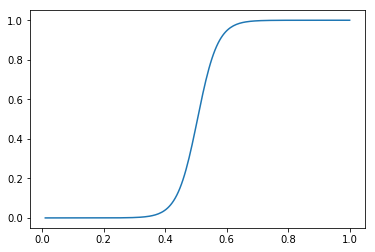

In [38]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [39]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_FNN_bce, fn_number_list_FNN_bce, 
 delay_list_FNN_bce, fp_delay_list_FNN_bce) = get_pareto_metrics_for_threshold(model_FNN_bce, final_test_loader, 
                                                                               threshold_list, LSTM_flag=False)

In [40]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_FNN_custom, fn_number_list_FNN_custom, 
 delay_list_FNN_custom, fp_delay_list_FNN_custom) = get_pareto_metrics_for_threshold(model_FNN_custom, final_test_loader, 
                                                                                     threshold_list, LSTM_flag=False)

In [41]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_FNN_combined, fn_number_list_FNN_combined, 
 delay_list_FNN_combined, fp_delay_list_FNN_combined) = get_pareto_metrics_for_threshold(model_FNN_combined, final_test_loader, 
                                                                                         threshold_list, LSTM_flag=False)

In [42]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_bce, fn_number_list_LSTM_bce, 
 delay_list_LSTM_bce, fp_delay_list_LSTM_bce) = get_pareto_metrics_for_threshold(model_LSTM_bce, final_test_loader, 
                                                                                 threshold_list, LSTM_flag=True)

In [43]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_custom, fn_number_list_LSTM_custom, 
 delay_list_LSTM_custom, fp_delay_list_LSTM_custom) = get_pareto_metrics_for_threshold(model_LSTM_custom, final_test_loader, 
                                                                                       threshold_list, LSTM_flag=True)

In [44]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size, shuffle=False)

(fp_number_list_LSTM_combined, fn_number_list_LSTM_combined, delay_list_LSTM_combined, fp_delay_list_LSTM_combined) = get_pareto_metrics_for_threshold(model_LSTM_combined, final_test_loader, threshold_list, LSTM_flag=True)

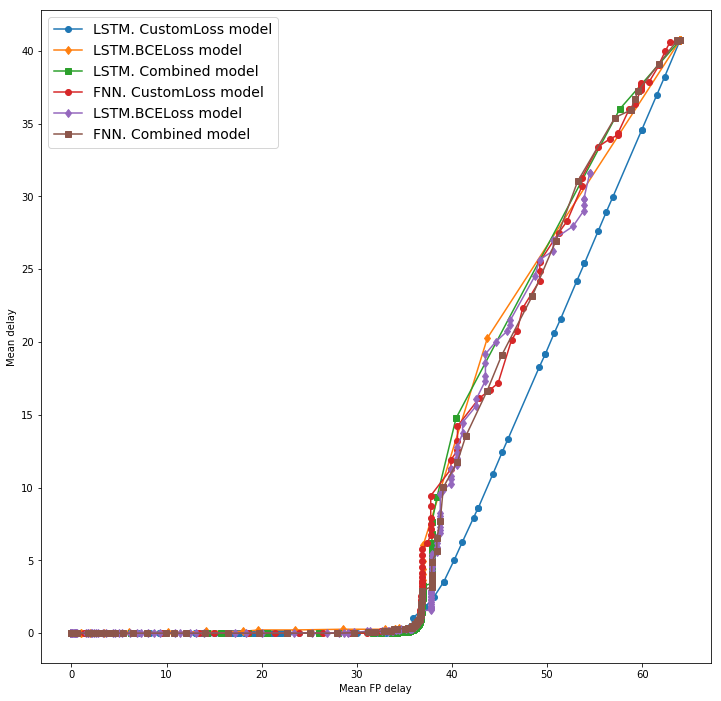

In [45]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list_LSTM_custom, delay_list_LSTM_custom, '-o', label='LSTM. CustomLoss model')
plt.plot(fp_delay_list_LSTM_bce, delay_list_LSTM_bce, '-d', label='LSTM.BCELoss model')
plt.plot(fp_delay_list_LSTM_combined, delay_list_LSTM_combined, '-s', label='LSTM. Combined model')
plt.plot(fp_delay_list_FNN_custom, delay_list_FNN_custom, '-o', label='FNN. CustomLoss model')
plt.plot(fp_delay_list_FNN_bce, delay_list_FNN_bce, '-d', label='LSTM.BCELoss model')
plt.plot(fp_delay_list_FNN_combined, delay_list_FNN_combined, '-s', label='FNN. Combined model')



plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
#plt.yscale('log')
plt.legend(loc='upper left', fontsize=14);